In [80]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sklearn as sk
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering 
from sklearn import preprocessing
import seaborn as sn
from mpl_toolkits.mplot3d import Axes3D 
import os
import sys

## 1 Datenset laden

Zuerst laden wir das gemergte Datenset.
Die Uhrzeit jedes Spiels und damit auch die der hinzugefügten Wetterdaten ist 3:00:00 PM, weil die Uhrzeiten nur bei 10% der Daten die exakte Uhrzeit vorhanden war. Für homogenität haben wir in den Daten auf die wenigen genauen Uhrzeiten verzichtet und alle gleichgesetzt.

In [73]:
data = pd.read_csv("mergedData.csv")
data.head(6)

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,D1,6/1/20,3:00:00 PM,FC Koln,RB Leipzig,2,4,A,1,2,...,27,7,19,34,0.0,1021,27,10,25,6
1,D1,5/31/20,3:00:00 PM,M'gladbach,Union Berlin,4,1,H,2,0,...,20,24,14,45,0.0,1022,20,10,62,21
2,D1,5/31/20,3:00:00 PM,Paderborn,Dortmund,1,6,A,0,0,...,17,20,36,59,0.0,1023,17,10,54,17
3,D1,5/30/20,3:00:00 PM,Hertha,Augsburg,2,0,H,1,0,...,18,29,51,40,0.0,1023,18,10,24,25
4,D1,5/30/20,3:00:00 PM,Mainz,Hoffenheim,0,1,A,0,1,...,20,24,18,30,0.0,1022,20,10,58,22
5,D1,5/30/20,3:00:00 PM,Schalke 04,Werder Bremen,0,1,A,0,1,...,21,23,33,34,0.0,1023,21,10,70,20


Wir wollen Attribute löschen, die keinen Einfluss auf das spätere Clustering haben. Beispielsweise möchten wir Attribute löschen, deren Werte für alle Datenpunkte gleich sind. Diese werden wir löschen.

In [4]:
for i in data:
    if len(list(set(data[i]))) == 1:
        print(i)

Div
Time


In [5]:
data = data.drop('Div',axis=1) 
data = data.drop('Time',axis=1) 
data.head(6)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,...,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,6/1/20,FC Koln,RB Leipzig,2,4,A,1,2,A,7,...,27,7,19,34,0.0,1021,27,10,25,6
1,5/31/20,M'gladbach,Union Berlin,4,1,H,2,0,H,16,...,20,24,14,45,0.0,1022,20,10,62,21
2,5/31/20,Paderborn,Dortmund,1,6,A,0,0,D,10,...,17,20,36,59,0.0,1023,17,10,54,17
3,5/30/20,Hertha,Augsburg,2,0,H,1,0,H,12,...,18,29,51,40,0.0,1023,18,10,24,25
4,5/30/20,Mainz,Hoffenheim,0,1,A,0,1,A,18,...,20,24,18,30,0.0,1022,20,10,58,22
5,5/30/20,Schalke 04,Werder Bremen,0,1,A,0,1,A,12,...,21,23,33,34,0.0,1023,21,10,70,20


Die Bedeutungen der Attribute können folgenden Tabellen entnommen werden:

Fussball

|Attribut          | Bedeutung                                                 |
|------------------|-----------------------------------------------------------|
|Date              | Date                                                      |
|HomeTeam          | Home Team                                                 |
|AwayTeam          | Away Team                                                 |
|FTHG              | Full Time Home Team Goals                                 |
|FTAG              | Full Time Away Team Goals                                 |
|FTR               | Full Time Result (H=Home Win, D=Draw, A=Away Win)         |
|HTHG              | Half Time Home Team Goals                                 |
|HTAG              | Half Time Away Team Goals                                 |
|HTR               | Half Time Result (H=Home Win, D=Draw, A=Away Win)         |
|HS                | Home Team Shots                                           |
|AS                | Away Team Shots                                           |
|HST               | Home Team Shots on Tar                                    |
|AST               | Home Team Shots on Target                                 |
|HF                | Home Team Fouls Committed                                 |
|AF                | Away Team Fouls Committed                                 |
|HC                | Home Team Corners                                         |
|AC                | Away Team Corners                                         |
|HY                | Home Team Yellow Cards                                    |
|AY                | Away Team Yellow Cards                                    |
|HR                | Home Team Red Cards                                       |
|AR                | Away Team Red Cards                                       |

Wetter:

|Attribut          | Bedeutung                                                 |
|------------------|-----------------------------------------------------------|
|maxtempC          | Max Temperature in Celsius                                |
|mintempC          | Min Temperature in Celsius                                |
|totalSnow\_cm     | Total Snow in cm                                          |
|sunHour           | Total Sun Hours                                           |
|uvIndex           | UV-Index                                                  |
|uvIndex2          | UV-Index                                                  |
|moon\_illumination| Moon Illumination in \%                                   |     
|moonrise          | Time of Moonrise                                          |
|moonset           | Time of Moonset                                           |
|sunrise           | Time of Sunrise                                           |
|sunset            | Time os Sunset                                            |
|DewPointC         | Dew point in Celsius                                      | 
|FeelsLikeC        | Feeling Temperature in Celsius                            |
|HeatIndexC        | HeatIndex in Celcius                                      |
|WindChillC        | Wind Chill in Celcius                                     | 
|WindGustKmph      | Wind Gust in Km/h                                         |
|cloudcover        | Cloud Cover in \%                                         | 
|humidity          | Humidity in \%                                            |
|precipMM          | Precipitation  in mm                                      |
|pressure          | Pressure in Pascal                                        |
|tempC             | Average Temperature in Celsius                            |
|visibility        | Visibility in m                                           |
|winddirDegree     | Winddirection in Degree                                   |  
|windspeedKmph     | Windspeed in Km/h                                         |


## 2 Datenset erkunden und vorbereiten

In [6]:
data.shape

(3473, 46)

Wir wollen überprüfen, ob es Null-Werte gibt.

In [7]:
data.isnull().sum()

Date                 0
HomeTeam             0
AwayTeam             0
FTHG                 0
FTAG                 0
FTR                  0
HTHG                 0
HTAG                 0
HTR                  0
HS                   0
AS                   0
HST                  0
AST                  0
HF                   0
AF                   0
HC                   0
AC                   0
HY                   0
AY                   0
HR                   0
AR                   0
HomeCity             0
maxtempC             0
mintempC             0
totalSnow_cm         0
sunHour              0
uvIndex              0
uvIndex2             0
moon_illumination    0
moonrise             0
moonset              0
sunrise              0
sunset               0
DewPointC            0
FeelsLikeC           0
HeatIndexC           0
WindChillC           0
WindGustKmph         0
cloudcover           0
humidity             0
precipMM             0
pressure             0
tempC                0
visibility 

Es gibt keine Null-Werte.

Um zu clustern dürfen wir nur Attribute mit numerischen Werten verwenden. Somit wollen wir nicht-numerische Werte in numerische Werte umwandeln.

##### Datum und Zeit

Wir konvertieren jetzt alle Datums- und Zeitspalten in Integer, wobei wir die datatime Klasse von Pandas benutzen.

In [74]:
data['Date'] = pd.to_datetime(data.Date)
data['Weekday'] = data.Date.dt.dayofweek
data['Month'] = data.Date.dt.month
data = data.drop('Date',axis=1) 

print(data['Weekday'])
print(data['Month'])

0       0
1       6
2       6
3       5
4       5
       ..
3468    5
3469    5
3470    5
3471    5
3472    4
Name: Weekday, Length: 3473, dtype: int64
0       6
1       5
2       5
3       5
4       5
       ..
3468    1
3469    1
3470    1
3471    1
3472    1
Name: Month, Length: 3473, dtype: int64


In [9]:
data['sunrise'] = pd.to_datetime(data.sunrise)
data['sunrise'] = data.sunrise.dt.hour*60 + data.sunrise.dt.minute
data['sunset'] = pd.to_datetime(data.sunset)
data['sunset'] = data.sunset.dt.hour*60 + data.sunset.dt.minute

print(data['sunrise'])
print(data['sunset'])

0       324
1       325
2       313
3       291
4       324
       ... 
3468    541
3469    530
3470    537
3471    534
3472    549
Name: sunrise, Length: 3473, dtype: int64
0       1298
1       1300
2       1293
3       1278
4       1286
        ... 
3468    1089
3469    1071
3470    1099
3471    1099
3472    1079
Name: sunset, Length: 3473, dtype: int64


In [10]:
data['moonrise']=data['moonrise'].replace('No moonrise', '0:00:00 AM')
data['moonset']=data['moonset'].replace('No moonset', '0:00:00 AM')

data['moonrise'] = pd.to_datetime(data.moonrise)
data['moonset'] = pd.to_datetime(data.moonset)

data['moonrise'] = data.moonrise.dt.hour*60 + data.moonrise.dt.minute
data['moonset'] = data.moonset.dt.hour*60 + data.moonset.dt.minute

print(data['moonrise'])
print(data['moonset'])

0       955
1       874
2       864
3       760
4       788
       ... 
3468    626
3469    609
3470    632
3471    631
3472    611
Name: moonrise, Length: 3473, dtype: int64
0        215
1        197
2        188
3        149
4        164
        ... 
3468       0
3469       0
3470       0
3471       0
3472    1391
Name: moonset, Length: 3473, dtype: int64


##### Numeric variable type
Attribute mit numerischen Werten wie FTHG, FTAG,  HTHG, HTAG, HS, AS, HST, AST, HF, AF, HC, AC, HY, AY, HR, AR und alle Wetterdaten müssen nicht verändert werden. Dennoch wollen wir auf Ausreißer überprüfen mithilfe von Histogrammen. 

Numerische Attribute der Fußball-Daten:

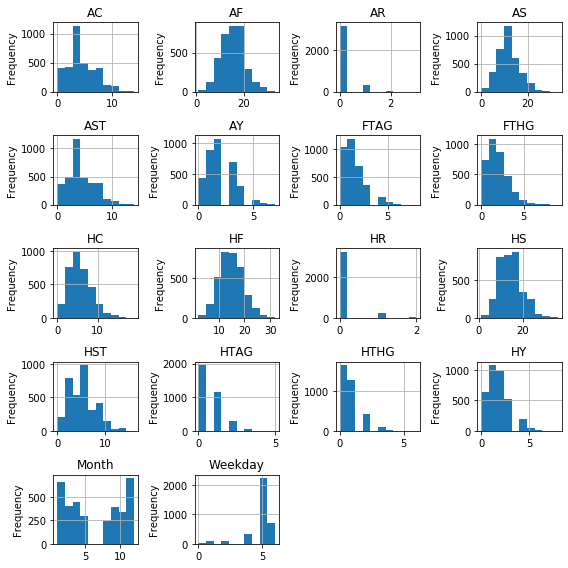

In [11]:
header1 = ['Month','Weekday','FTHG', 'FTAG',  'HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST', 
          'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']

fig = data.hist(column=header1,figsize=(8,8))

for i in fig:
    for j in i:
        j.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

Wir haben die Endzeit- mit den Halbzeitspielständen subtrahiert, um die Verteilung von Toren der beiden Teams pro Halbzeit und insgesamt zu untersuchen:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B6E6DA7C88>]],
      dtype=object)

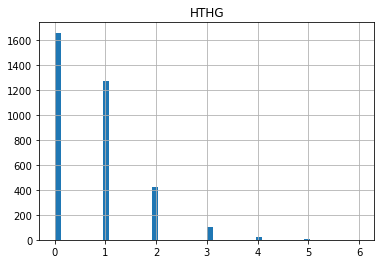

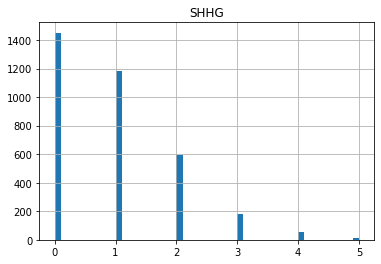

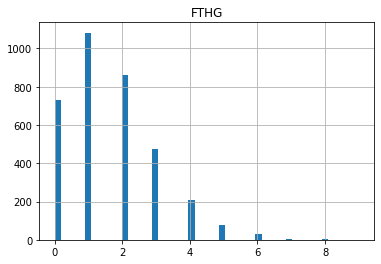

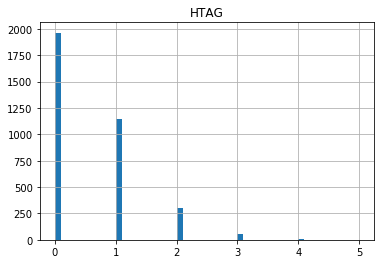

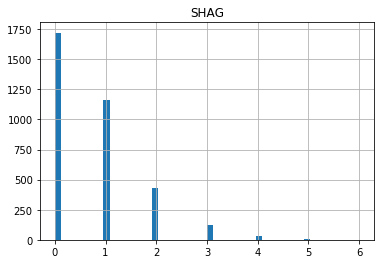

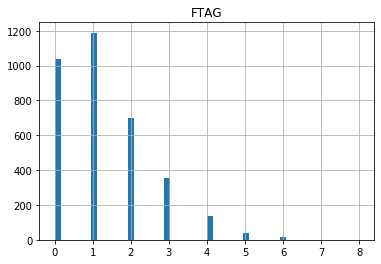

In [12]:
data['SHAG'] = data['FTAG'] - data['HTAG'] # Second Half Away team Goals
data['SHHG'] = data['FTHG'] - data['HTHG'] # Second Half Home team Goals
data.hist(column='HTHG', bins=50)
data.hist(column='SHHG', bins=50)
data.hist(column='FTHG', bins=50)
data.hist(column='HTAG', bins=50)
data.hist(column='SHAG', bins=50)
data.hist(column='FTAG', bins=50)

Die Kurven deuten auf eine Poisson-Verteilung der Tore hin.

Als nächstes plotten wir die Histogramme der Wetter-Daten:

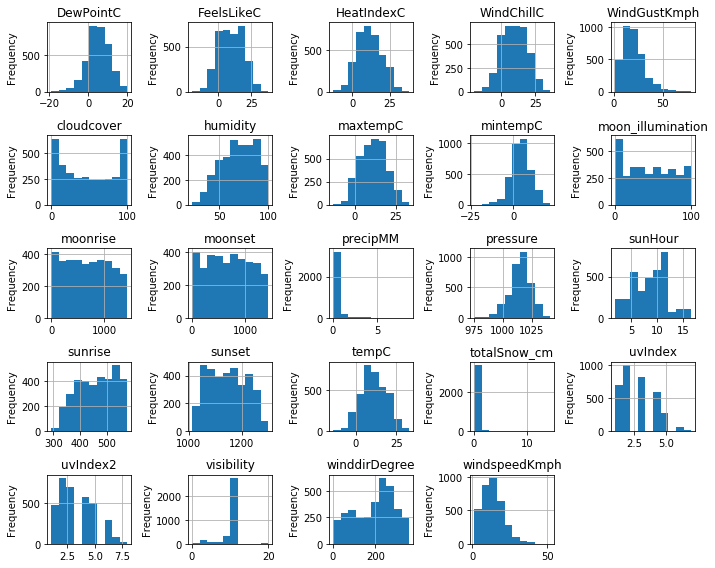

In [13]:
header2 = ['maxtempC', 'mintempC',
       'totalSnow_cm', 'sunHour', 'uvIndex', 'uvIndex2', 'moon_illumination',
       'moonrise', 'moonset', 'sunrise', 'sunset', 'DewPointC', 'FeelsLikeC',
       'HeatIndexC', 'WindChillC', 'WindGustKmph', 'cloudcover', 'humidity',
       'precipMM', 'pressure', 'tempC', 'visibility', 'winddirDegree',
       'windspeedKmph']

fig = data.hist(column=header2,figsize=(10,8))

for i in fig:
    for j in i:
        j.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

Die Daten wirken sinnig, weswegen wir keine Datenpunkte verwerfen.

##### Geordnete und nominale Attributstypen
Die restlichen Attribute haben nominale Werte. Wir separieren diese in geordnete und nominale Attribute (hier wird das erklärt, wieso man diese Unterscheidung macht: https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/). 

Um einzuschätzen, welcher Attributstyp geordnet oder nicht ist, geben wir alle Werte aus. 

In [14]:
for i in data:
    if not(i in header1) and not(i in header2) and not(i in ['SHAG','SHHG']):
        print(i,list(set(data[i])))

HomeTeam ['Nurnberg', 'Hoffenheim', 'Freiburg', "M'gladbach", 'Karlsruhe', 'Braunschweig', 'Paderborn', 'Bochum', 'Kaiserslautern', 'Mainz', 'Cottbus', 'Schalke 04', 'Greuther Furth', 'St Pauli', 'Augsburg', 'Ein Frankfurt', 'FC Koln', 'Werder Bremen', 'RB Leipzig', 'Fortuna Dusseldorf', 'Bielefeld', 'Hannover', 'Ingolstadt', 'Union Berlin', 'Hamburg', 'Dortmund', 'Wolfsburg', 'Bayern Munich', 'Hertha', 'Darmstadt', 'Leverkusen', 'Stuttgart']
AwayTeam ['Nurnberg', 'Hoffenheim', 'Freiburg', 'Karlsruhe', 'Braunschweig', 'Paderborn', 'Bochum', 'Kaiserslautern', 'Mainz', 'Cottbus', 'Schalke 04', 'Greuther Furth', 'St Pauli', 'Augsburg', 'Ein Frankfurt', 'FC Koln', 'Werder Bremen', 'RB Leipzig', 'Fortuna Dusseldorf', 'Bielefeld', 'Hannover', 'Ingolstadt', 'Union Berlin', 'Hamburg', 'Dortmund', 'Wolfsburg', 'Hertha', 'Bayern Munich', "M'gladbach", 'Darmstadt', 'Leverkusen', 'Stuttgart']
FTR ['A', 'H', 'D']
HTR ['A', 'H', 'D']
HomeCity ['München', 'Köln', 'Gelsenkirchen', 'Freiburg', 'Mönchen

Nun müssen wir vom Inhalt her entscheiden, ob eine Variable geordnet ist oder nicht. FTR und HTR haben wir als geordnet eingeschätzt und den Rest als nominal. Die nominalen Werte wie HomeTeam, AwayTeam und HomeCity lassen wir so, da wir sie nicht in das Clustering miteinbeziehen. 

In [15]:
data['FTR'] = data['FTR'].map({'D': 0,'A': -1,'H': 1})
data['HTR'] = data['HTR'].map({'D': 0,'A': -1,'H': 1})

data.head()

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,...,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,Weekday,Month,SHAG,SHHG
0,FC Koln,RB Leipzig,2,4,-1,1,2,-1,7,19,...,0.0,1021,27,10,25,6,0,6,2,1
1,M'gladbach,Union Berlin,4,1,1,2,0,1,16,13,...,0.0,1022,20,10,62,21,6,5,1,2
2,Paderborn,Dortmund,1,6,-1,0,0,0,10,16,...,0.0,1023,17,10,54,17,6,5,6,1
3,Hertha,Augsburg,2,0,1,1,0,1,12,8,...,0.0,1023,18,10,24,25,5,5,0,1
4,Mainz,Hoffenheim,0,1,-1,0,1,-1,18,13,...,0.0,1022,20,10,58,22,5,5,0,0


Außerdem ergänzen wir die Daten um die Attribute rain, FeelsHot, accuracy_home/away, efficiency_home/away, FTTG, TS, TST, accuracy, efficiency, balance (definiert durch bestehende Attribute bzw. erkenntlich im Code).

In [16]:
# rain: 1 if rain 0 else
data['rain'] = data['precipMM'].astype(int)
data['rain'][(data['precipMM'] > 0)] = 1
data['rain']

# FeelsHot: 0 if cold, 1 if medium, 2 if warm
data['FeelsHot'] = np.zeros(data['FeelsLikeC'].shape).astype(int)
data['FeelsHot'][data['FeelsLikeC'] > 5] = 1
data['FeelsHot'][data['FeelsLikeC'] > 20] = 2

data['accuracy_home'] = data['HST'] / data['HS'] # Rate of on target shots Home team
data['accuracy_away'] = data['AST'] / data['AS'] # Rate of on target shots Away team
data['efficiency_home'] = data['FTHG'] / data['HS'] # Goals per shot Home team
data['efficiency_away'] = data['FTAG'] / data['AS'] # Goals per shot Away team
data['FTTG'] = data['FTHG'] + data['FTAG'] # Full time Total Goals
data['TS'] = data['HS'] + data['AS'] # total shots
data['TST'] = data['HST'] + data['AST'] # total shots on target
data['accuracy'] = data['TST'] / data['TS'] # total accuracy 
data['efficiency'] = data['FTTG'] / data['TS'] # total efficiency
data['balance'] = (data['FTHG']+1) / (data['FTAG']+1) # balance
data.head(5)

C:\Users\Tim\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Tim\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Tim\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,...,accuracy_home,accuracy_away,efficiency_home,efficiency_away,FTTG,TS,TST,accuracy,efficiency,balance
0,FC Koln,RB Leipzig,2,4,-1,1,2,-1,7,19,...,0.714286,0.421053,0.285714,0.210526,6,26,13,0.500000,0.230769,0.600000
1,M'gladbach,Union Berlin,4,1,1,2,0,1,16,13,...,0.625000,0.384615,0.250000,0.076923,5,29,15,0.517241,0.172414,2.500000
2,Paderborn,Dortmund,1,6,-1,0,0,0,10,16,...,0.100000,0.687500,0.100000,0.375000,7,26,12,0.461538,0.269231,0.285714
3,Hertha,Augsburg,2,0,1,1,0,1,12,8,...,0.500000,0.250000,0.166667,0.000000,2,20,8,0.400000,0.100000,3.000000
4,Mainz,Hoffenheim,0,1,-1,0,1,-1,18,13,...,0.111111,0.461538,0.000000,0.076923,1,31,8,0.258065,0.032258,0.500000


Hier geben wir die Durchschnitte unserer neuen Werte aus:

In [17]:
print("Means:")
print('Halftime home team goals: ', data['HTHG'].mean())
print('Second half home team goals: ', data['SHHG'].mean())
print('Fulltime home team goals: ', data['FTHG'].mean())
print('Halftime away team goals: ', data['HTAG'].mean())
print('Second half away team goals: ', data['SHAG'].mean())
print('Fulltime away team goals: ', data['FTAG'].mean())

Means:
Halftime home team goals:  0.7232939821479989
Second half home team goals:  0.9167866397926865
Fulltime home team goals:  1.6400806219406854
Halftime away team goals:  0.5588828102505039
Second half away team goals:  0.7348114022458969
Fulltime away team goals:  1.2936942124964008


## 3 Suche nach Abhängigkeiten in den Daten, um Attribute für das Clustering auszuwählen

### Correlation Matrix

Um lineare Abhängigkeiten herauszufinden, eignet sich eine Korrelationsmatrix. Folgender Link wurde für den Code genutzt: https://seaborn.pydata.org/examples/many_pairwise_correlations.html.

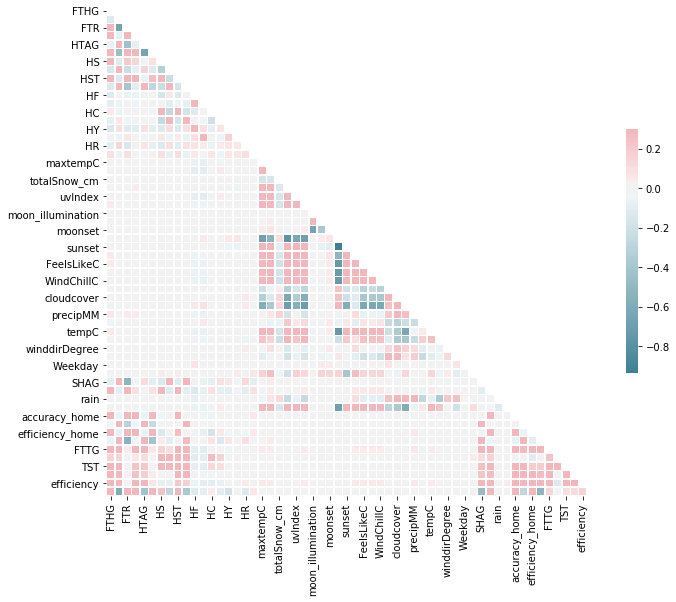

In [18]:
corrMatrix=data.corr()

mask = np.triu(np.ones_like(corrMatrix, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sn.diverging_palette(220, 10, as_cmap=True)
sn.heatmap(corrMatrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Außerdem lassen wir uns die größten Korrelationswerte ausgeben:

In [19]:
array = np.absolute(np.array(corrMatrix))
i_max, j_max = corrMatrix.shape
corr_in_line = np.zeros(i_max)
for i in range(i_max):
    for j in range(j_max):
        if (corrMatrix.columns[j] == 'balance' and i != j):
            corr_in_line[i] += array[i][j]
            print(corrMatrix.columns[i], array[i][j])

FTHG 0.7233345728100877
FTAG 0.5984171047936333
FTR 0.7258656225489657
HTHG 0.4861004400076369
HTAG 0.4140590077290282
HTR 0.5561010485050764
HS 0.23322580337642973
AS 0.27055549602655177
HST 0.45203056058029206
AST 0.385084810533127
HF 0.12124700195343024
AF 0.08539055410808669
HC 0.040095053213547
AC 0.09590570615925205
HY 0.17683063898151377
AY 0.013425198253650026
HR 0.1373198335070464
AR 0.06320201364903438
maxtempC 0.016668429511461552
mintempC 0.007140221976200682
totalSnow_cm 0.01897782648485728
sunHour 0.033155692344934776
uvIndex 0.022492426761297712
uvIndex2 0.030679507621596696
moon_illumination 0.0061263596851301935
moonrise 0.005135380587809474
moonset 0.0016625559228065764
sunrise 0.016237867598261284
sunset 0.009453287442913204
DewPointC 0.017519681550312017
FeelsLikeC 0.026323964429549505
HeatIndexC 0.023748386812871686
WindChillC 0.025623206955236465
WindGustKmph 0.013007863094046428
cloudcover 0.036491199319470834
humidity 0.02555618667844733
precipMM 0.0280575024985

Innerhalb der Bundesliga-Daten und der Wetterdaten gibt es lineare Abhängigkeiten. Jedoch leider kaum zwischen ihnen. Deswegen untersuchen wir weiter auf nicht-lineare Abhängigkeiten.

### Untersuchung auf nicht-lineare Abhängigkeiten

Nicht-lineare Abhängigkeiten können in Scatterplots ersichtlich werden. Beispielhaft haben wir eine Auswahl von Plots hier, die wir genutzt haben, um Abhängigkeiten zu sehen.

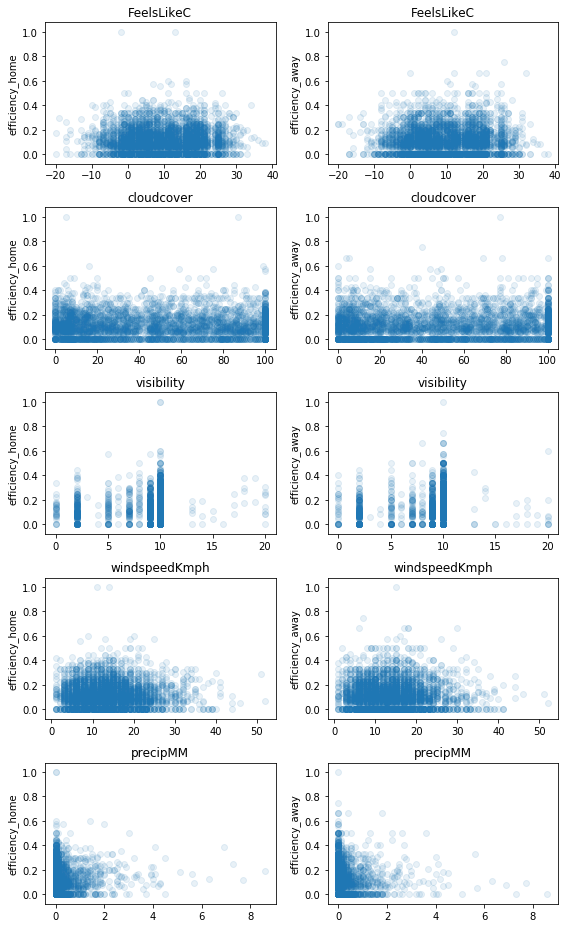

In [20]:
parameter = ['FeelsLikeC', 'cloudcover', 'visibility', 'windspeedKmph', 'precipMM']

fig, axs = plt.subplots(len(parameter), 2, figsize = (8,13))
for row in range(len(parameter)):
    axs[row][0].scatter(data[parameter[row]], data['efficiency_home'], alpha = 0.1)
    axs[row][0].set_title(parameter[row])
    axs[row][0].set_ylabel("efficiency_home")
    axs[row][1].scatter(data[parameter[row]], data['efficiency_away'], alpha = 0.1)
    axs[row][1].set_title(parameter[row])
    axs[row][1].set_ylabel("efficiency_away")
plt.tight_layout()
plt.show()

In diesen Plots scheinen einige Abhängigkeiten sichtbar zu werden. Diese sind jecoh höchstwahrscheinlich trügerisch.
Die gefundenen Strukturen werden wohl nicht durch Abhängigkeiten erzeugt, sondern dadurch, dass an manchen stellen der x-Achsen wesentlich mehr Datenpunkte zu finden sind als an anderen. Die Ansammlung vieler Datenpunkte verursacht statistisch eine höhere maximale Abweichung, was aussieht wie ein höherer Mittelwert. Wir gehen also von unabhängigkeit zwischen den Daten aus, auch aufgrund der geringen Kovarianzen, die bei Abhängigkeit, bei den nicht symmetrischen Fällen höher wären.

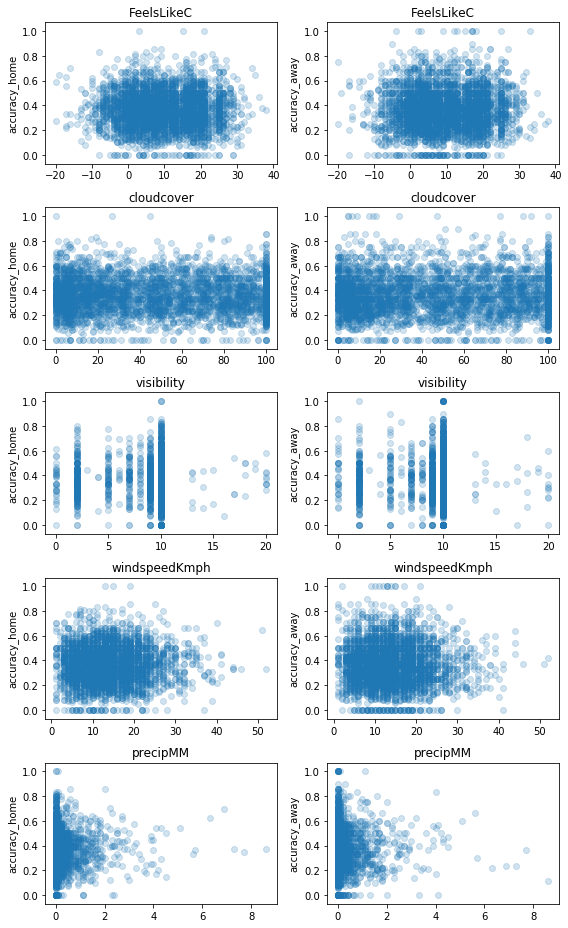

In [21]:
parameter = ['FeelsLikeC', 'cloudcover', 'visibility', 'windspeedKmph', 'precipMM']
fig, axs = plt.subplots(len(parameter), 2, figsize = (8,13))
fig.tight_layout()
for row in range(len(parameter)):
    axs[row][0].scatter(data[parameter[row]], data['accuracy_home'], alpha = 0.2)
    axs[row][0].set_title(parameter[row])
    axs[row][0].set_ylabel("accuracy_home")
    axs[row][1].scatter(data[parameter[row]], data['accuracy_away'], alpha = 0.2)
    axs[row][1].set_title(parameter[row])
    axs[row][1].set_ylabel("accuracy_away")
    
plt.tight_layout()
plt.show()

Als nächstes Plotten wir uns einige Parameter in Abhängikeit vom jeweiligen Monat.

C:\Users\Tim\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Tim\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Tim\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Tim\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Tim\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Tim\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Tim\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Tim\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
C:\U

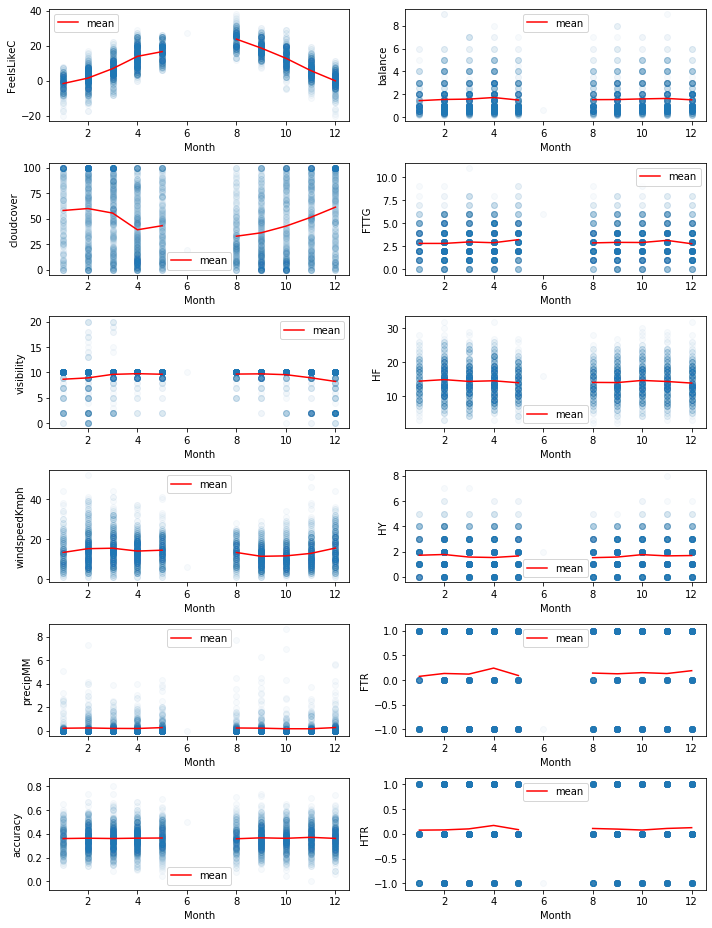

In [22]:
parameter1 = ['FeelsLikeC', 'cloudcover', 'visibility', 'windspeedKmph', 'precipMM', 'accuracy', 'balance', 'FTTG', 'HF', 'HY', 'FTR', 'HTR']
width = 12
count = np.zeros(width)
for x in data['Month']:
    count[x - 1] += 1
fig, axs = plt.subplots(6, 2, figsize = (10,13))
for row in range(int(len(parameter1)/2)):
    for column in range(2):
        axs[row][column].scatter(data['Month'], data[parameter1[row+column*6]], alpha = 0.03)
        axs[row][column].set_ylabel(parameter1[row+column*6])
        axs[row][column].set_xlabel('Month')
        
        width = 12
        sum = np.zeros(width)
        for i in range(len(data[parameter1[row+column*6]])):
            sum[data['Month'][i] - 1] += data[parameter1[row+column*6]][i]
        count[5] = 0
        axs[row][column].plot(range(1, len(count) + 1), sum/count,color="red",label="mean")
        axs[row][column].legend()
fig.tight_layout()
plt.show()

Wie wir sehen, gibt es vor allem beim Wetter ein paar Abhängigkeiten von der Jahreszeit, was nicht verwundert. Jedoch gibt es auch bei Ergebnis (FTR) einen kleinen Peak im April, was bedeutet, dass die Heimmannschaft im April am ehesten gewinnt.

## 4 Analyse mit Clustering-Algorithmen

### 4.1 These 1 (Schussanzahl und Spielsieg): Eine hohe Anzahl der Schüsse in Richtung des gegnerischen Tors geht mit dem Spielsieg einher.

Um unsere These zu bestätigen gehen wir vor wie im Bericht beschrieben und wählen nur stark korrelierte Attribute aus.

In [23]:
X_orig = data[['HS', 'HST', 'AS', 'AST']] 
X_orig[np.isnan(X_orig)] = 0 # replace nan's with zeros
X_orig[:5]

C:\Users\Tim\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Tim\anaconda3\lib\site-packages\pandas\core\frame.py:2986: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


,HS,HST,AS,AST
0,7,5,19,8
1,16,10,13,5
2,10,1,16,11
3,12,6,8,2
4,18,2,13,6


Aus den anfänglichen Histogrammen wissen wir, dass sich die Werte von Attributen stark voneinander unterscheiden. Also normieren wir sie, um Attribute "fair" zu betrachten. D.h. alle Means auf 0 und alle Standardabweichungen auf 1.

In [24]:
X = preprocessing.StandardScaler().fit(X_orig).transform(X_orig)
X[0:2]

array([[-1.41034449, -0.06035426,  1.58023373,  1.56393914],
       [ 0.33614486,  1.83485687,  0.28259382,  0.3122352 ]])

###### Anwendung von K-Means:

In [25]:
k_means = KMeans(init = "k-means++", n_clusters = 4, n_init = 12)
k_means.fit(X)
k_means_labels = k_means.labels_
k_means_labels
data['k_means_labels'] = k_means_labels

###### Anwendung von AHC:

In [26]:
agglom = AgglomerativeClustering(n_clusters = 4, linkage = 'complete')
agg_labels = agglom.fit_predict(X_orig)
data['agg_labels'] = agg_labels

###### Vergleich und Plots:

In [82]:
# create folder for saved figures if not exists
if not os.path.exists('Bilder'):
    os.makedirs('Bilder')

K-Means


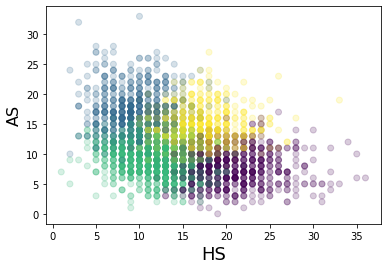

K-Means:
 2    1245
3     779
0     733
1     716
Name: k_means_labels, dtype: int64
Agglomerative


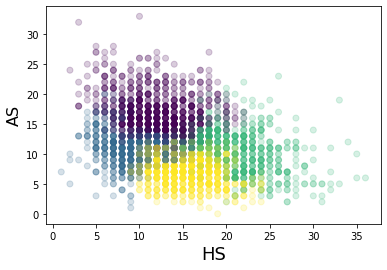

Agglomerative:
 0    1036
3     962
1     786
2     689
Name: agg_labels, dtype: int64


In [77]:
# Plot of AS and HS and clusters

print("K-Means")
X_orig = np.array(X_orig)
area = np.pi * ( X_orig[:, 2])**2  
plt.scatter(X_orig[:, 0], X_orig[:, 2], c=k_means_labels.astype(np.float), alpha=0.2) #s=area,
plt.xlabel('HS', fontsize=18)
plt.ylabel('AS', fontsize=16)
plt.savefig("Bilder/these1_2D_KM.pdf")
plt.show()
print("K-Means:\n", data["k_means_labels"].value_counts())

print("Agglomerative")
X_orig = np.array(X_orig)
area = np.pi * ( X_orig[:, 2])**2  
plt.scatter(X_orig[:, 0], X_orig[:, 2], c=agg_labels.astype(np.float), alpha=0.2) #s=area,
plt.xlabel('HS', fontsize=18)
plt.ylabel('AS', fontsize=16)
plt.savefig("Bilder/these1_2D_AHC.pdf")
plt.show()
print("Agglomerative:\n", data["agg_labels"].value_counts())

Wir sehen, dass k-Means eher in einer '+' Form clustert, während das hierarchische Clustering eher in einer 'x' Form clustert.

K-Means


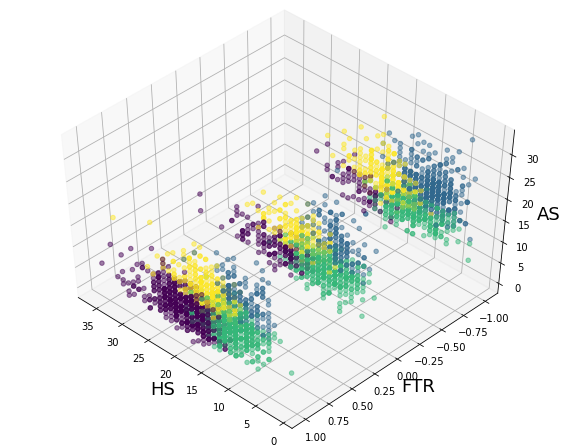

Agglomerative


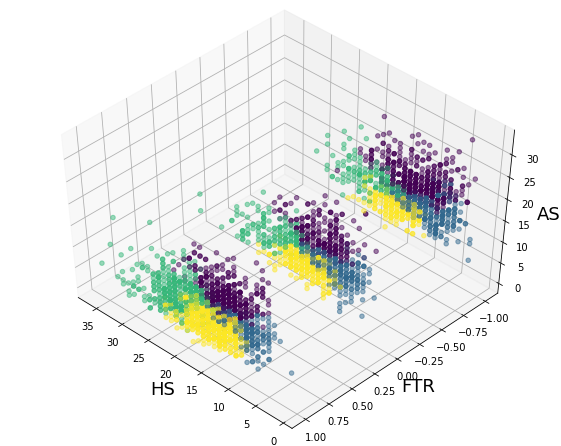

In [67]:
# Plot of HS, AS and FTR and clusters

print("K-Means")
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
plt.cla()
ax.set_xlabel('HS',fontsize=18)
ax.set_ylabel('FTR',fontsize=18)
ax.set_zlabel('AS',fontsize=18)
ax.scatter(X_orig[:, 0], data['FTR'], X_orig[:, 2], c= data['k_means_labels'].astype(np.float), alpha = 0.5) 
plt.savefig("Bilder/these1KM_FTR.pdf")
plt.show()

print("Agglomerative")
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
plt.cla()
ax.set_xlabel('HS',fontsize=18)
ax.set_ylabel('FTR',fontsize=18)
ax.set_zlabel('AS',fontsize=18)
ax.scatter(X_orig[:, 0], data['FTR'], X_orig[:, 2], c= data['agg_labels'].astype(np.float), alpha = 0.5) 
plt.savefig("Bilder/these1AHC_FTR.pdf")
plt.show()

Wie wir sehen Variieren die Anteile der Punkte pro Ergebnis cor allem bei K-Means.

In [29]:
# Plot the matrix of means with respect to clusters and result

k_means_games = data.groupby(['k_means_labels','FTR'])['FTHG', 'FTAG', 'HS', 'HST', 'AS', 'AST'].mean()
print(k_means_games)
agg_games = data.groupby(['agg_labels','FTR'])['FTHG', 'FTAG', 'HS', 'HST', 'AS', 'AST'].mean()
print(agg_games)

                        FTHG      FTAG         HS       HST         AS  \
k_means_labels FTR                                                       
0              -1   0.702703  2.135135  21.364865  7.405405   8.391892   
                0   1.208633  1.208633  21.043165  7.359712   8.007194   
                1   3.198077  0.580769  20.142308  8.632692   7.590385   
1              -1   0.641975  2.943210   9.461728  2.817284  16.738272   
                0   1.270270  1.270270   9.972973  3.398649  17.317568   
                1   2.141104  0.687117   9.809816  4.000000  17.570552   
2              -1   0.449405  1.985119  12.330357  3.154762   9.684524   
                0   0.734908  0.734908  11.944882  3.417323   9.278215   
                1   2.106061  0.403409  11.820076  4.339015   9.500000   
3              -1   0.951220  2.577236  16.910569  5.804878  13.772358   
                0   1.561111  1.561111  16.477778  5.922222  13.727778   
                1   2.713881  0.844193

C:\Users\Tim\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Tim\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


Wir sehen, dass die Mittelwerte der Attribute innerhalb eines Clusters zwischen verschiedenen Spielergebnissen (FTR) stark schwankt, was die in den Plots beobachtete Abhängigkeit zwischen FTR und den clusteringparametern unterstreicht, da nach FTR nicht geclustert wurde.

In [30]:
# print the centers reusluting from the k-means clustering, if you search for those points in the graph they are
# in the middle of each cluster

k_means_cluster_centers = k_means.cluster_centers_
print(k_means_cluster_centers)

[[ 1.19707913  1.17812614 -0.85276735 -0.72089015]
 [-0.89675087 -0.7400892   1.15795705  1.14029446]
 [-0.44085196 -0.53895216 -0.47827135 -0.54535794]
 [ 0.40240733  0.43303318  0.50247632  0.50183862]]


In [31]:
# Outputting distribution of clusters depending on FTR

Zahlen_km = np.zeros((4, 3))
for i in range(len(data['FTR'])):
    Zahlen_km[k_means_labels[i]][data['FTR'][i] + 1] += 1
probabilities_km = np.zeros(Zahlen_km.shape)
for i in range(4):
    for j in range(3):
        probabilities_km[i][j] = Zahlen_km[i][j] / np.sum(Zahlen_km[i])

Zahlen_agg = np.zeros((4, 3))
for i in range(len(data['FTR'])):
    Zahlen_agg[agg_labels[i]][data['FTR'][i] + 1] += 1
probabilities_agg = np.zeros(Zahlen_agg.shape)
for i in range(4):
    for j in range(3):
        probabilities_agg[i][j] = Zahlen_agg[i][j] / np.sum(Zahlen_agg[i])
        
print('K-Means:')
print(Zahlen_km)
print(probabilities_km)
n = np.sum(np.sum(Zahlen_agg))
print(np.sum(Zahlen_km[:,0]) / n, np.sum(Zahlen_km[:,1]) / n, np.sum(Zahlen_km[:,2]) / n)
print('')

print('Agglomerative:')
print(Zahlen_agg)
print(probabilities_agg)
print(np.sum(Zahlen_agg[:,0]) / n, np.sum(Zahlen_agg[:,1]) / n, np.sum(Zahlen_agg[:,2]) / n)

K-Means:
[[ 74. 139. 520.]
 [405. 148. 163.]
 [336. 381. 528.]
 [246. 180. 353.]]
[[0.10095498 0.18963165 0.70941337]
 [0.56564246 0.20670391 0.22765363]
 [0.26987952 0.3060241  0.42409639]
 [0.31578947 0.23106547 0.45314506]]
0.30549956809674633 0.2441693060754391 0.4503311258278146

Agglomerative:
[[421. 223. 392.]
 [305. 233. 248.]
 [157. 155. 377.]
 [178. 237. 547.]]
[[0.40637066 0.21525097 0.37837838]
 [0.38804071 0.29643766 0.31552163]
 [0.22786647 0.22496372 0.54716981]
 [0.18503119 0.24636175 0.56860707]]
0.30549956809674633 0.2441693060754391 0.4503311258278146


Silhouette Score:

In [32]:
print("K-Means: ", round(sk.metrics.silhouette_score(X_orig, k_means_labels), 4))
print("Agglomerative: ", round(sk.metrics.silhouette_score(X_orig, agg_labels), 4))

K-Means:  0.2304
Agglomerative:  0.169


Die Silhouette Scores sind sehr gering, was bedeutet, dass die Daten keine klar definierten Gruppen enthalten. Das ist jedoch nicht schlimm, da wir die Cluster nicht zur klaren abgrenzung der Spiele voneinander benutzen sondern die Spiele in Gruppen einteilen wollen, deren Häufigkeit wir in Abhängigkeit von bestimmten Bedingungen (hier Ergebnis) erforschen. Dafür bedarf es keiner abgegrenzten Cluster

### 4.2 These 2 (Teamstrategie): Man kann Teams der Bundesliga abhängig von Anzahl der Fouls, Gelben Karten, Roten Karten und von Spielerfolg in Gruppen einordnen.

Hier werden die Schritte wie vorher mit anderen Parameterwerten wiederholt.

In [33]:
#Preprocessing:
parameters3 = ['FTR', 'HF', 'HY', 'HR']
X_orig3 = data[parameters3] 
X_orig3[np.isnan(X_orig3)] = 0 # replace nan's with zeros
X3 = preprocessing.StandardScaler().fit(X_orig3).transform(X_orig3)
n_clusters3 = 6

#K-Means:
k_means3 = KMeans(init = "k-means++", n_clusters = n_clusters3, n_init = 12)
k_means3.fit(X3)
k_means_labels3 = k_means3.labels_
k_means_labels3
data['k_means_labels3'] = k_means_labels3
k_means_cluster_centers3 = k_means3.cluster_centers_
k_means_cluster_centers3

#Agglomerative:
agglom3 = AgglomerativeClustering(n_clusters = n_clusters3, linkage = 'complete')
agg_labels3 = agglom3.fit_predict(X_orig3)
data['agg_labels3'] = agg_labels3

C:\Users\Tim\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Tim\anaconda3\lib\site-packages\pandas\core\frame.py:2986: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


K-Means


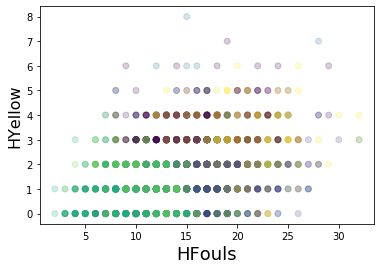

K-Means:
 4    868
3    828
1    714
5    406
0    405
2    252
Name: k_means_labels3, dtype: int64
Agglomerative


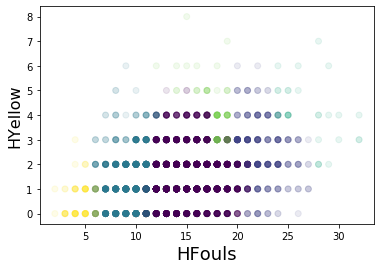

Agglomerative:
 0    2083
2     847
1     320
4     110
5      80
3      33
Name: agg_labels3, dtype: int64


In [34]:
# Plot of HFouls and HYellow and clusters

print("K-Means")
X_orig3 = np.array(X_orig3)
plt.scatter(X_orig3[:, 1], X_orig3[:, 2], c=k_means_labels3.astype(np.float), alpha=0.2) #s=area,
plt.xlabel('HFouls', fontsize=18)
plt.ylabel('HYellow', fontsize=16)
plt.show()
print("K-Means:\n", data["k_means_labels3"].value_counts())

print("Agglomerative")
plt.scatter(X_orig3[:, 1], X_orig3[:, 2], c=agg_labels3.astype(np.float), alpha=0.1) #s=area,
plt.xlabel('HFouls', fontsize=18)
plt.ylabel('HYellow', fontsize=16)
plt.show()
print("Agglomerative:\n", data["agg_labels3"].value_counts())

Wie wir an den geprinteten Tabellen sehen, sind die Datenpunkte im K-Means Cluster einigermaßen gleichmäßig verteilt, während im hierarchischem Clustering zwei sehr große Cluster dominieren. Als nächstes sehen wir uns die Mittelwerte der Cluster an um uns ein Bild der Aufteilung zu machen.
Die Cluster hier können von denen im Dokument abweichen, wenn der Code neu ausgeführt wird, da so ein neues Clustering durchgeführt wird.

In [66]:
# Print means of each cluster to understand what kind of games are represented by the clusters

print(data.groupby(['k_means_labels3'])[parameters3].mean().round(2))
print("Anahl pro Cluster:")
print(data.groupby(['k_means_labels3']).count()['HomeTeam'])
print(data.groupby(['agg_labels3'])[parameters3].mean().round(2))
print("Anahl pro Cluster:")
print(data.groupby(['agg_labels3']).count()['HomeTeam'])
print("Gesamt Durchschnitt:")
print(data[parameters3].mean())

                  FTR     HF    HY    HR
k_means_labels3                         
0                0.64  16.00  3.41  0.00
1                0.70  17.84  1.39  0.00
2               -0.30  15.60  1.94  1.05
3                0.90  10.20  0.80  0.00
4               -0.67  12.13  1.19  0.00
5               -0.86  18.92  2.78  0.00
Anahl pro Cluster:
k_means_labels3
0    405
1    714
2    252
3    828
4    868
5    406
Name: HomeTeam, dtype: int64
              FTR     HF    HY    HR
agg_labels3                         
0            0.11  15.18  1.56  0.08
1            0.02  22.28  2.48  0.09
2            0.28   9.26  1.24  0.06
3            0.15  26.76  4.06  0.15
4            0.03  17.95  3.78  0.15
5            0.22   4.61  0.50  0.04
Anahl pro Cluster:
agg_labels3
0    2083
1     320
2     847
3      33
4     110
5      80
Name: HomeTeam, dtype: int64
Gesamt Durchschnitt:
FTR     0.144832
HF     14.342355
HY      1.636337
HR      0.076015
dtype: float64


Auffällig ist hierbei, dass K-Means alle spiele mit roten Karten in ein Cluster packt und sonst viel nach Spielausgang clustert, sodass sich die durchschnittlichen Spielausgänge zum Teil stark unterscheiden. 
Beim hierarchischem Clustering hingegen variieren Spielausgang und Karten weniger und vorallem die durchschnittlichen Fouls gehen mehr in die Extreme. Anders als bei K-Means, wo die cluster gleichmäßiger verteilt waren, gibt es beim hierar. Clustering ein sehr großes Cluster (0 mit 2083 Spielen), welches etwa dem Durchschnitt aller Spiele entspricht. Cluster 2 stellt ca 850 fairere Spiele mit weniger Fouls und mehr Siegen dar. Die anderen, wesentlich kleineren Cluster, sind Randfälle mit besonders vielen bzw. wenigen Fouls und Karten.


In [46]:
# Outputting distribution of clusters depending on Teams

teams = list(set(data["HomeTeam"]))
Zahlen_km3 = np.zeros((n_clusters3, len(teams)))
for i in range(len(data['HomeTeam'])):
    for j in range(len(teams)):
        if (teams[j] == data["HomeTeam"][i]):
            Zahlen_km3[k_means_labels3[i]][j] += 1
probabilities_km3 = np.zeros(Zahlen_km3.T.shape)    
for j in range(n_clusters3):
    for i in range(len(teams)):
        probabilities_km3[i][j] = Zahlen_km3.T[i][j] / np.sum(Zahlen_km3.T[i])
        
Zahlen_agg3 = np.zeros((n_clusters3, len(teams)))
for i in range(len(data['HomeTeam'])):
    for j in range(len(teams)):
        if (teams[j] == data["HomeTeam"][i]):
            Zahlen_agg3[agg_labels3[i]][j] += 1
probabilities_agg3 = np.zeros(Zahlen_agg3.T.shape)
for j in range(n_clusters3):
    for i in range(len(teams)):
        probabilities_agg3[i][j] = Zahlen_agg3.T[i][j] / np.sum(Zahlen_agg3.T[i])

# only teams with more than 100 home games
teams_del = teams
for i in range(len(teams) - 1, -1, -1):
    if (np.sum(Zahlen_agg3[:, i]) <= 100):
        Zahlen_agg3 = np.delete(Zahlen_agg3, i, 1)
        Zahlen_km3 = np.delete(Zahlen_km3, i, 1)
        probabilities_agg3 = np.delete(probabilities_agg3, i, 0)
        probabilities_km3 = np.delete(probabilities_km3, i, 0)
        teams_del = np.delete(teams_del, i, 0)

total_probabilities_agg = probabilities_agg3.sum(axis=0)/len(teams_del)
total_probabilities_km = probabilities_km3.sum(axis=0)/len(teams_del)

print('K-Means:')
print(Zahlen_km3.T)
print(probabilities_km3)
print("Gesamt Klassifierungs Wahrscheinlichkeiten: ")
print("K-Means:", total_probabilities_km)
print('')
print('Agglomerative:')
print(Zahlen_agg3.T)
print(probabilities_agg3)
print("Gesamt Klassifierungs Wahrscheinlichkeiten: ")
print("Agglomerative:", total_probabilities_agg)

K-Means:
[[  9.  21.   8.  15.  37.  12.]
 [ 29.  46.  10.  32.  51.  25.]
 [ 17.  37.  11.  34.  53.  15.]
 [ 12.  32.  10.  74.  51.  14.]
 [ 29.  33.  14.  32.  58.  19.]
 [ 21.  53.  14.  48.  42.  16.]
 [ 23.  32.   4.  24.  45.  22.]
 [ 37.  45.  13.  19.  32.  30.]
 [ 20.  23.  13.  20.  47.  20.]
 [ 23.  39.  13.  37.  47.  32.]
 [ 23.  40.  14.  25.  41.  18.]
 [ 29.  39.  14.  17.  35.  28.]
 [ 10.  37.  11. 101.  28.   5.]
 [ 16.  42.  18.  44.  50.  24.]
 [ 11.  25.   6. 125.  26.   1.]
 [ 18.  33.  10.  34.  42.  22.]
 [ 20.  43.  17.  59.  36.  17.]
 [ 18.  37.  20.  29.  36.  21.]]
[[0.08823529 0.20588235 0.07843137 0.14705882 0.3627451  0.11764706]
 [0.15025907 0.23834197 0.05181347 0.16580311 0.2642487  0.12953368]
 [0.10179641 0.22155689 0.06586826 0.20359281 0.31736527 0.08982036]
 [0.06217617 0.16580311 0.05181347 0.38341969 0.2642487  0.07253886]
 [0.15675676 0.17837838 0.07567568 0.17297297 0.31351351 0.1027027 ]
 [0.10824742 0.27319588 0.07216495 0.24742268 0.216

Da die Tabellen ein bisschen unübersichtlich sind plotten wir sie nochmal grpahisch.

K-Means


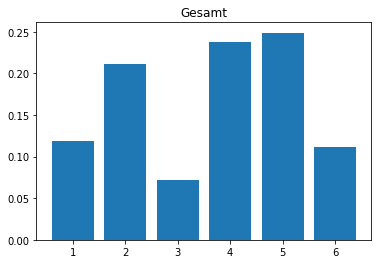

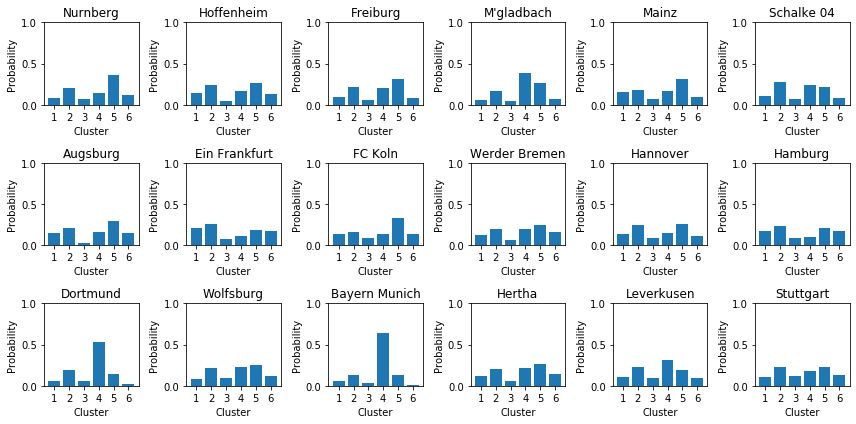

Agglomerative


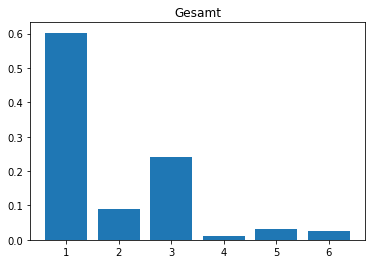

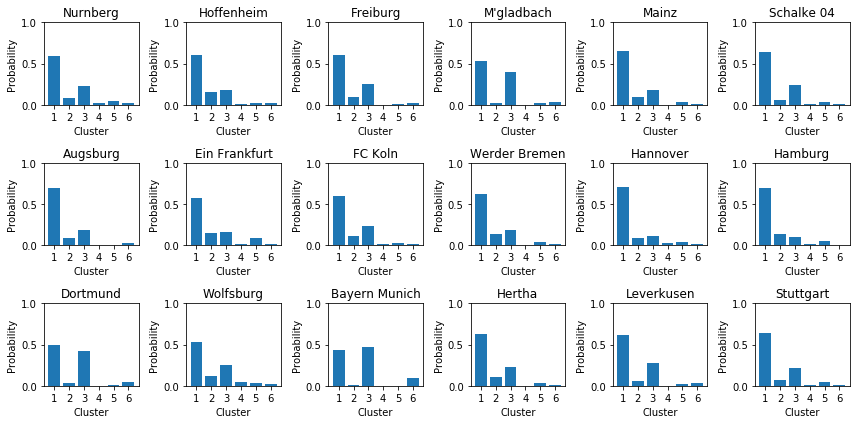

In [52]:
# Plot cluster distributions of all teams with more than 100 games
print("K-Means")
plt.bar([1,2,3,4,5,6],total_probabilities_km)
plt.title('Gesamt')
plt.show()
fig, axs = plt.subplots(3,6, figsize = (12,6))
for row in range(3):
    for column in range(6):
        axs[row][column].bar([1,2,3,4,5,6],probabilities_km3[column+row*6])
        axs[row][column].set_title(teams_del[column+row*6])
plt.setp(axs, xticks=[1,2,3,4,5,6],yticks=[0.0,0.5,1.0],xlabel=("Cluster"),ylabel=("Probability"))
fig.tight_layout()
plt.savefig("Bilder/These2_allteams.pdf")
plt.show()

print("Agglomerative")
plt.bar([1,2,3,4,5,6],total_probabilities_agg)
plt.title('Gesamt')
plt.show()
fig, axs = plt.subplots(3,6, figsize = (12,6))
for row in range(3):
    for column in range(6):
        axs[row][column].bar([1,2,3,4,5,6],probabilities_agg3[column+row*6])
        axs[row][column].set_title(teams_del[column+row*6])
plt.setp(axs, xticks=[1,2,3,4,5,6],yticks=[0.0,0.5,1.0],xlabel=("Cluster"),ylabel=("Probability"))
fig.tight_layout()
plt.savefig("Bilder/These2_allteams.pdf")
plt.show()


Wie man sehen kann variieren die Clusterverteilungen der einzelnen Teams. Manche Teams stellen ungefähr die Verteilung des gesamt clusterings dar, wöhrend andere stark abweichen. Es gibt also zwischen den Mannschaften unterschiede in der Spielweise.

Silhouette Score:

In [38]:
print("K-Means: ", round(sk.metrics.silhouette_score(X_orig3, k_means_labels3), 6))
print("Agglomerative: ", round(sk.metrics.silhouette_score(X_orig3, agg_labels3), 6))

K-Means:  0.061379
Agglomerative:  0.171657


Wir betrachten ein paar Teams etwas genauer:


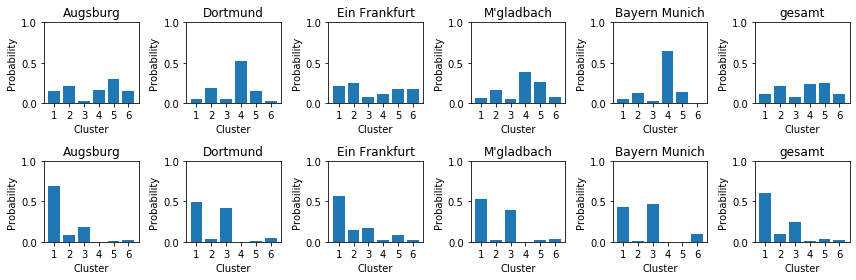

In [70]:
relevant_teams = ['Augsburg', 'Dortmund', 'Ein Frankfurt', "M'gladbach", 'Bayern Munich', 'gesamt'] # 6,12,7,3,14
relevant_prob_km = np.concatenate((probabilities_km3[[6,12,7,3,14]], [total_probabilities_km]))
relevant_prob_agg = np.concatenate((probabilities_agg3[[6,12,7,3,14]], [total_probabilities_agg])) 
fig, axs = plt.subplots(2,6, figsize = (12,4))
for column in range(6):
    #k means
    axs[0][column].bar([1,2,3,4,5,6],relevant_prob_km[column])
    axs[0][column].set_title(relevant_teams[column])
    #agglomerative
    axs[1][column].bar([1,2,3,4,5,6],relevant_prob_agg[column])
    axs[1][column].set_title(relevant_teams[column])
plt.setp(axs, xticks=[1,2,3,4,5,6],yticks=[0.0,0.5,1.0],xlabel=("Cluster"),ylabel=("Probability"))
fig.tight_layout()
plt.savefig("Bilder/These2_relevant_teams.pdf")
plt.show()

### Analyse zu K-Means:
Zwichen den Mannschaften sind klare Unterschiede erkennbar. Bayern München und Bor. Dortmund sind oft in Cluster 4 (Viele Siege, wenige Fouls/Karten) und seltener in Cluster 3 (Rote Karten) und 6 (Viele Niederlagen, viele Fouls und Karten) vertreten. Augsburg ist bei sont eher durchschnittlicher Verteilung, genau wie München selten in Cluster 3 (Rot), was wenige Platzverweise bedeutet. Eintracht Frankfurt ist im Verhältnis zu Cluster 2 (Viele Fouls, wenige gelbe Karten) häufig in Cluster 1 (etwas weniger Fouls, viele gelbe Karten). Dies deutet darauf hin, dass die Eintracht bei überlegenheit häufig mehr Karten für weniger Fouls bekommt. Außerdem ist sie verhältnismäßig oft in Cluster 6 (Unterlegen, Viele Fouls/Karten) im Verh. zu 5 (Unterlegen, Wenig Fouls/Karten). Das bedeutet, dass sie bei unterlegenheit mehr Fouls und Karten bekommt als andere Teams.
### Analyse zu AHC:
Alle Teams sind zum Großteil in den großen Clustern 1 und 3 vertreten, vermeintlich stärkere Teams, wie z.B. Bayern und Dortmund sind häufiger in 3 (fairer, erfolgreicher) als vermeintlich schwächere Teams wie z.B. Eintracht und Augsburg. Auch hier ist bemerkbar, dass Frankfurt häufig in Clustern mit mehr Fouls und Karten (2, 4, 5) ist, als andere Teams wie z.B. Augsburg. 
### Fazit:
Beide Clustermethoden geben also ähnliche Erkenntnisse über unteschiedliche Spielverhalten der Teams. Als besser geeignet sehen wir in diesem Fall das K-Means clustering, da die Cluster gleichmäßiger verteilt sind und die Mittelwerte im Ausgang des Spiels mehr variieren, was die Analyse erleichtert. Beim hierar. Clustering fallen viele Spiele in zwei Cluster, wodurch Spiele innerhalb eines Clusters stark variieren und viele Informationen verloren gehen.


### 4.3 These 3 (Teamstrategie): (Niederschlag und Schussanzahl): Niederschlag am Spieltag geht mit einer jeweils niedrigen Schussanzahl in Richtung des gegnerischen Tors des Heim- und Auswärtsteam einher. 

K-Means


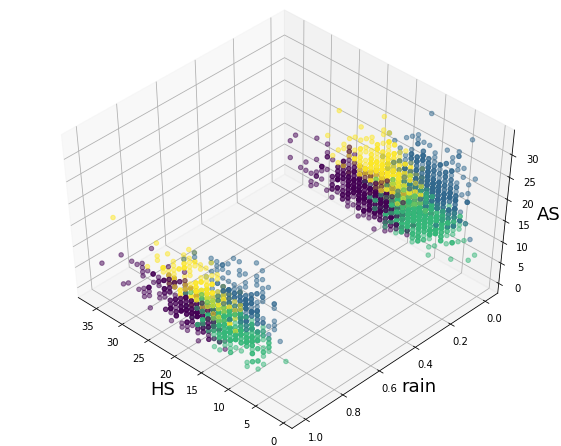

Agglomerative


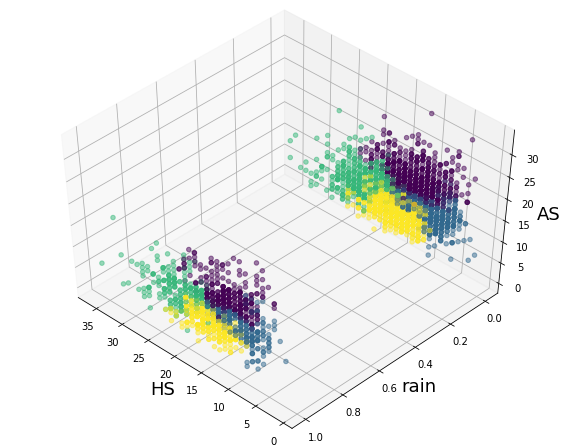

In [69]:
# Plot of HS, AS and rain and clusters

print("K-Means")
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
plt.cla()
ax.set_xlabel('HS', fontsize=18)
ax.set_ylabel('rain', fontsize=18)
ax.set_zlabel('AS', fontsize=18)
ax.scatter(X_orig[:, 0], data['rain'], X_orig[:, 2], c= data['k_means_labels'].astype(np.float), alpha = 0.5) 
plt.savefig("Bilder/these3KM_rain.pdf")
plt.show()

print("Agglomerative")
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
plt.cla()
ax.set_xlabel('HS', fontsize=18)
ax.set_ylabel('rain', fontsize=18)
ax.set_zlabel('AS', fontsize=18)
ax.scatter(X_orig[:, 0], data['rain'], X_orig[:, 2], c= data['agg_labels'].astype(np.float), alpha = 0.5) 
plt.savefig("Bilder/these3AHC_rain.pdf")
plt.show()

In [ ]:
# Outputting distribution of clusters depending on rain

n_clusters = 4
Zahlen_km = np.zeros((n_clusters, 2))
for i in range(len(data['rain'])):
    Zahlen_km[k_means_labels[i]][data['rain'][i]] += 1
probabilities_km = np.zeros(Zahlen_km.shape)
for i in range(n_clusters):
    for j in range(2):
        probabilities_km[i][j] = Zahlen_km[i][j] / np.sum(Zahlen_km[i])
        
Zahlen_agg = np.zeros((n_clusters, 2))
for i in range(len(data['rain'])):
    Zahlen_agg[agg_labels[i]][data['rain'][i]] += 1
probabilities_agg2 = np.zeros(Zahlen_agg.shape)
for i in range(n_clusters):
    for j in range(2):
        probabilities_agg[i][j] = Zahlen_agg[i][j] / np.sum(Zahlen_agg[i])


print('Agglomerative:')
print(Zahlen_agg)
print(probabilities_agg)
print("Gesamt Regen Wahrscheinlichkeiten: ", np.sum(Zahlen_agg[:,0]) / n, np.sum(Zahlen_agg[:,1]) / n)

print('')
print('K-Means:')
print(Zahlen_km)
print(probabilities_km)
n = np.sum(np.sum(Zahlen_agg))
print("Gesamt Regen Wahrscheinlichkeiten: ", np.sum(Zahlen_km[:,0]) / n, np.sum(Zahlen_km[:,1]) / n)

Fazit: Für Regen konnten wir leider keine Abhängigkeiten finden. Außerdem haben wir auch für Temperatur in drei verschiedenen Klassen ('FeelsHot') keine Abhängigkeit finden können.
